Using device: cuda
Epoch 1/10
[CAM] Train Loss: 0.1393 | Val Loss: 0.1392
[NO_CAM] Train Loss: 0.1429 | Val Loss: 0.1338
--------------------------------------------------
Epoch 2/10
[CAM] Train Loss: 0.1203 | Val Loss: 0.0912
[NO_CAM] Train Loss: 0.1381 | Val Loss: 0.1351
--------------------------------------------------
Epoch 3/10
[CAM] Train Loss: 0.1024 | Val Loss: 0.0852
[NO_CAM] Train Loss: 0.1369 | Val Loss: 0.1314
--------------------------------------------------
Epoch 4/10
[CAM] Train Loss: 0.0844 | Val Loss: 0.0786
[NO_CAM] Train Loss: 0.1278 | Val Loss: 0.1122
--------------------------------------------------
Epoch 5/10
[CAM] Train Loss: 0.0745 | Val Loss: 0.0675
[NO_CAM] Train Loss: 0.1113 | Val Loss: 0.0924
--------------------------------------------------
Epoch 6/10
[CAM] Train Loss: 0.0705 | Val Loss: 0.0584
[NO_CAM] Train Loss: 0.0909 | Val Loss: 0.0700
--------------------------------------------------
Epoch 7/10
[CAM] Train Loss: 0.0673 | Val Loss: 0.0478
[NO_CAM]

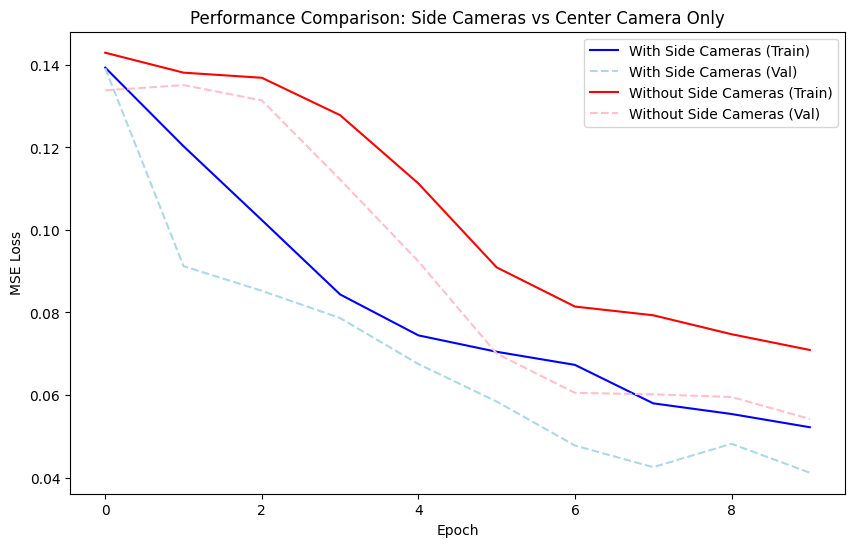

In [ ]:
# 对比使用两侧摄像头和仅使用中心摄像头的模型性能
# 仅使用中心摄像头通过数据增强生成伪左右摄像头数据保持两种训练集大小一致
# 验证集并非相同，结果仅供参考

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import ntpath
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from imgaug import augmenters as iaa
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# %%

# 原始数据加载
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
data['center'] = data['center'].apply(lambda x: ntpath.split(x)[1])
data['left'] = data['left'].apply(lambda x: ntpath.split(x)[1])
data['right'] = data['right'].apply(lambda x: ntpath.split(x)[1])

# %%

def load_img_steering(datadir, df, use_side_cameras=True):
    image_path = []
    steering = []
    for i in range(len(df)):
        indexed_data = df.iloc[i]
        center = indexed_data['center'].strip()
        steering_center = float(indexed_data['steering'])
        
        # 中心图像
        image_path.append(os.path.join(datadir, center))
        steering.append(steering_center)
        
        if use_side_cameras:
            # 真实左右摄像头数据
            left = indexed_data['left'].strip()
            right = indexed_data['right'].strip()
            image_path.append(os.path.join(datadir, left))
            steering.append(steering_center + 0.15)
            image_path.append(os.path.join(datadir, right))
            steering.append(steering_center - 0.15)
        else:
            # 使用中心图像生成伪左右数据
            image_path.append(os.path.join(datadir, center))  # 伪左摄像头
            steering.append(steering_center + 0.15)
            image_path.append(os.path.join(datadir, center))  # 伪右摄像头
            steering.append(steering_center - 0.15)
    
    return np.array(image_path), np.array(steering)

# %%

def balance_dataset(image_paths, steerings, samples_per_bin=400, num_bins=25):
    df = pd.DataFrame({'image_path': image_paths, 'steering': steerings})
    hist, bins = np.histogram(df['steering'], num_bins)
    
    remove_list = []
    for j in range(num_bins):
        bin_indices = []
        for i in range(len(df)):
            if bins[j] <= df['steering'].iloc[i] <= bins[j+1]:
                bin_indices.append(i)
        bin_indices = shuffle(bin_indices)
        remove_list.extend(bin_indices[samples_per_bin:])
    
    df_balanced = df.drop(remove_list)
    return df_balanced['image_path'].values, df_balanced['steering'].values

# %%

# 生成两种数据集
image_paths_cam, steerings_cam = load_img_steering(os.path.join(datadir, 'IMG'), data, use_side_cameras=True)
image_paths_nocam, steerings_nocam = load_img_steering(os.path.join(datadir, 'IMG'), data, use_side_cameras=False)

# 平衡数据
X_cam, y_cam = balance_dataset(image_paths_cam, steerings_cam)
X_nocam, y_nocam = balance_dataset(image_paths_nocam, steerings_nocam)

# 拆分数据集
X_train_cam, X_valid_cam, y_train_cam, y_valid_cam = train_test_split(X_cam, y_cam, test_size=0.2, random_state=6)
X_train_nocam, X_valid_nocam, y_train_nocam, y_valid_nocam = train_test_split(X_nocam, y_nocam, test_size=0.2, random_state=6)

# %%

# 数据集和数据加载器定义（保持与原代码一致）

class DrivingDataset(Dataset):
    def __init__(self, image_paths, steering_angles, is_training=True):
        self.image_paths = image_paths
        self.steering_angles = steering_angles
        self.is_training = is_training

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        steering = self.steering_angles[idx]

        image = mpimg.imread(img_path)

        if self.is_training and random.random() < 0.5:
            image, steering = self.random_augment(image, steering)

        image = self.preprocess(image)
        return image, torch.tensor(steering, dtype=torch.float32)

    def random_augment(self, image, steering):
        if np.random.rand() < 0.5:
            image = iaa.Affine(translate_percent={
                               "x": (-0.1, 0.1), "y": (-0.1, 0.1)}).augment_image(image)
        if np.random.rand() < 0.5:
            image = iaa.Affine(scale=(1, 1.3)).augment_image(image)
        if np.random.rand() < 0.5:
            image = iaa.Multiply((0.2, 1.2)).augment_image(image)
        if np.random.rand() < 0.5:
            image = cv2.flip(image, 1)
            steering = -steering
        return image, steering

    def preprocess(self, image):
        image = image[60:135, :, :]
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        image = cv2.GaussianBlur(image, (3, 3), 0)
        image = cv2.resize(image, (200, 66))
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)  # HWC to CHW
        return image


# %%

# 模型定义（保持与原代码一致）
class NVIDIA_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.ELU(),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(1152, 100),
            nn.ELU(),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.Linear(50, 10),
            nn.ELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


# %%

# 修改后的训练函数
def train_and_compare():
    # 训练使用两侧摄像头的模型
    train_dataset_cam = DrivingDataset(X_train_cam, y_train_cam, is_training=True)
    valid_dataset_cam = DrivingDataset(X_valid_cam, y_valid_cam, is_training=False)
    train_loader_cam = DataLoader(train_dataset_cam, batch_size=100, shuffle=True, num_workers=4)
    valid_loader_cam = DataLoader(valid_dataset_cam, batch_size=100, shuffle=False, num_workers=4)
    
    model_cam = NVIDIA_Model().to(device)
    optimizer_cam = optim.Adam(model_cam.parameters(), lr=1e-3)
    train_losses_cam, val_losses_cam = [], []
    
    # 训练不使用两侧摄像头的模型
    train_dataset_nocam = DrivingDataset(X_train_nocam, y_train_nocam, is_training=True)
    valid_dataset_nocam = DrivingDataset(X_valid_nocam, y_valid_nocam, is_training=False)
    train_loader_nocam = DataLoader(train_dataset_nocam, batch_size=100, shuffle=True, num_workers=4)
    valid_loader_nocam = DataLoader(valid_dataset_nocam, batch_size=100, shuffle=False, num_workers=4)
    
    model_nocam = NVIDIA_Model().to(device)
    optimizer_nocam = optim.Adam(model_nocam.parameters(), lr=1e-3)
    train_losses_nocam, val_losses_nocam = [], []
    

    # 训练循环
    for epoch in range(10):
        # ==================== 训练带摄像头的模型 ====================
        model_cam.train()
        train_loss_cam = 0.0
        for images, labels in train_loader_cam:
            images = images.to(device)
            labels = labels.to(device)

            # 前向传播
            optimizer_cam.zero_grad()
            outputs = model_cam(images)
            loss = F.mse_loss(outputs.squeeze(), labels)

            # 反向传播
            loss.backward()
            optimizer_cam.step()

            train_loss_cam += loss.item() * images.size(0)

        # 记录平均训练损失
        epoch_train_loss_cam = train_loss_cam / len(train_loader_cam.dataset)
        train_losses_cam.append(epoch_train_loss_cam)

        # ==================== 验证带摄像头的模型 ====================
        model_cam.eval()
        val_loss_cam = 0.0
        with torch.no_grad():
            for images, labels in valid_loader_cam:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model_cam(images)
                loss = F.mse_loss(outputs.squeeze(), labels)
                val_loss_cam += loss.item() * images.size(0)

        # 记录平均验证损失
        epoch_val_loss_cam = val_loss_cam / len(valid_loader_cam.dataset)
        val_losses_cam.append(epoch_val_loss_cam)

        # ==================== 训练不带摄像头的模型 ====================
        model_nocam.train()
        train_loss_nocam = 0.0
        for images, labels in train_loader_nocam:
            images = images.to(device)
            labels = labels.to(device)

            # 前向传播
            optimizer_nocam.zero_grad()
            outputs = model_nocam(images)
            loss = F.mse_loss(outputs.squeeze(), labels)

            # 反向传播
            loss.backward()
            optimizer_nocam.step()

            train_loss_nocam += loss.item() * images.size(0)

        # 记录平均训练损失
        epoch_train_loss_nocam = train_loss_nocam / len(train_loader_nocam.dataset)
        train_losses_nocam.append(epoch_train_loss_nocam)

        # ==================== 验证不带摄像头的模型 ====================
        model_nocam.eval()
        val_loss_nocam = 0.0
        with torch.no_grad():
            for images, labels in valid_loader_nocam:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model_nocam(images)
                loss = F.mse_loss(outputs.squeeze(), labels)
                val_loss_nocam += loss.item() * images.size(0)

        # 记录平均验证损失
        epoch_val_loss_nocam = val_loss_nocam / len(valid_loader_nocam.dataset)
        val_losses_nocam.append(epoch_val_loss_nocam)

        # 打印进度
        print(f'Epoch {epoch+1}/10')
        print(
            f'[CAM] Train Loss: {epoch_train_loss_cam:.4f} | Val Loss: {epoch_val_loss_cam:.4f}')
        print(
            f'[NO_CAM] Train Loss: {epoch_train_loss_nocam:.4f} | Val Loss: {epoch_val_loss_nocam:.4f}')
        print('-' * 50)
    # 保存模型
    torch.save(model_cam.state_dict(), 'torchmodel/model_cam.pth')
    torch.save(model_nocam.state_dict(), 'torchmodel/model_nocam.pth')
    # 绘制对比曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_cam, label='With Side Cameras (Train)', color='blue')
    plt.plot(val_losses_cam, '--', label='With Side Cameras (Val)', color='lightblue')
    plt.plot(train_losses_nocam, label='Without Side Cameras (Train)', color='red')
    plt.plot(val_losses_nocam, '--',
             label='Without Side Cameras (Val)', color='pink')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Performance Comparison: Side Cameras vs Center Camera Only')
    plt.show()

# %%


# 执行训练并对比
train_and_compare()

Using device: cuda


/tmp/ipykernel_8496/3344483216.py:223: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/aten/src/ATen/native/Scalar.cpp:22.)
  train_loss_cam += loss.item() * images.size(0)


Epoch 1/10
[CAM] Train Loss: 0.1501 | Val Loss: 0.1554
[NO_CAM] Train Loss: 0.1382 | Val Loss: 0.1148
--------------------------------------------------


/tmp/ipykernel_8496/3344483216.py:276: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(outputs.squeeze(), labels)


Epoch 2/10
[CAM] Train Loss: 0.1395 | Val Loss: 0.1387
[NO_CAM] Train Loss: 0.1295 | Val Loss: 0.1131
--------------------------------------------------
Epoch 3/10
[CAM] Train Loss: 0.1373 | Val Loss: 0.1364
[NO_CAM] Train Loss: 0.1138 | Val Loss: 0.1320
--------------------------------------------------
Epoch 4/10
[CAM] Train Loss: 0.1328 | Val Loss: 0.1296
[NO_CAM] Train Loss: 0.1009 | Val Loss: 0.0820
--------------------------------------------------
Epoch 5/10
[CAM] Train Loss: 0.1164 | Val Loss: 0.0828
[NO_CAM] Train Loss: 0.0857 | Val Loss: 0.0729
--------------------------------------------------
Epoch 6/10
[CAM] Train Loss: 0.0902 | Val Loss: 0.0776
[NO_CAM] Train Loss: 0.0759 | Val Loss: 0.0730
--------------------------------------------------
Epoch 7/10
[CAM] Train Loss: 0.0787 | Val Loss: 0.0645
[NO_CAM] Train Loss: 0.0700 | Val Loss: 0.0598
--------------------------------------------------
Epoch 8/10
[CAM] Train Loss: 0.0705 | Val Loss: 0.0565
[NO_CAM] Train Loss: 0.0638

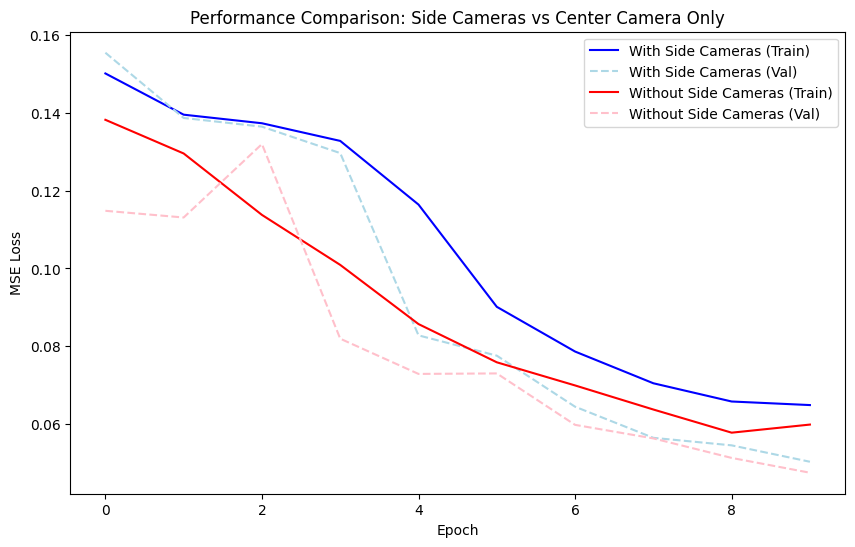

In [1]:
# %%

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pandas as pd
import ntpath
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from imgaug import augmenters as iaa
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# %%

# 原始数据加载
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
data['center'] = data['center'].apply(lambda x: ntpath.split(x)[1])
data['left'] = data['left'].apply(lambda x: ntpath.split(x)[1])
data['right'] = data['right'].apply(lambda x: ntpath.split(x)[1])

# %%

def load_img_steering(datadir, df, use_side_cameras=True):
    image_path = []
    steering = []
    for i in range(len(df)):
        indexed_data = df.iloc[i]
        center = indexed_data['center'].strip()
        steering_center = float(indexed_data['steering'])
        
        # 中心图像
        image_path.append(os.path.join(datadir, center))
        steering.append(steering_center)
        
        if use_side_cameras:
            # 真实左右摄像头数据
            left = indexed_data['left'].strip()
            right = indexed_data['right'].strip()
            image_path.append(os.path.join(datadir, left))
            steering.append(steering_center + 0.15)
            image_path.append(os.path.join(datadir, right))
            steering.append(steering_center - 0.15)
        else:
            # 复制中心图像替代左右数据
            image_path.append(os.path.join(datadir, center)) 
            steering.append(steering_center)
            image_path.append(os.path.join(datadir, center)) 
            steering.append(steering_center)
    
    return np.array(image_path), np.array(steering)

# %%

def balance_dataset(image_paths, steerings, samples_per_bin=400, num_bins=25):
    df = pd.DataFrame({'image_path': image_paths, 'steering': steerings})
    hist, bins = np.histogram(df['steering'], num_bins)
    
    remove_list = []
    for j in range(num_bins):
        bin_indices = []
        for i in range(len(df)):
            if bins[j] <= df['steering'].iloc[i] <= bins[j+1]:
                bin_indices.append(i)
        bin_indices = shuffle(bin_indices)
        remove_list.extend(bin_indices[samples_per_bin:])
    
    df_balanced = df.drop(remove_list)
    return df_balanced['image_path'].values, df_balanced['steering'].values

# %%

# 生成两种数据集
image_paths_cam, steerings_cam = load_img_steering(os.path.join(datadir, 'IMG'), data, use_side_cameras=True)
image_paths_nocam, steerings_nocam = load_img_steering(os.path.join(datadir, 'IMG'), data, use_side_cameras=False)

# 平衡数据
X_cam, y_cam = balance_dataset(image_paths_cam, steerings_cam)
X_nocam, y_nocam = balance_dataset(image_paths_nocam, steerings_nocam)

# 拆分数据集
X_train_cam, X_valid_cam, y_train_cam, y_valid_cam = train_test_split(X_cam, y_cam, test_size=0.2, random_state=6)
X_train_nocam, X_valid_nocam, y_train_nocam, y_valid_nocam = train_test_split(X_nocam, y_nocam, test_size=0.2, random_state=6)

# %%

# 数据集和数据加载器定义（保持与原代码一致）

class DrivingDataset(Dataset):
    def __init__(self, image_paths, steering_angles, is_training=True):
        self.image_paths = image_paths
        self.steering_angles = steering_angles
        self.is_training = is_training

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        steering = self.steering_angles[idx]

        image = mpimg.imread(img_path)

        if self.is_training and random.random() < 0.5:
            image, steering = self.random_augment(image, steering)

        image = self.preprocess(image)
        return image, torch.tensor(steering, dtype=torch.float32)

    def random_augment(self, image, steering):
        if np.random.rand() < 0.5:
            image = iaa.Affine(translate_percent={
                               "x": (-0.1, 0.1), "y": (-0.1, 0.1)}).augment_image(image)
        if np.random.rand() < 0.5:
            image = iaa.Affine(scale=(1, 1.3)).augment_image(image)
        if np.random.rand() < 0.5:
            image = iaa.Multiply((0.2, 1.2)).augment_image(image)
        if np.random.rand() < 0.5:
            image = cv2.flip(image, 1)
            steering = -steering
        return image, steering

    def preprocess(self, image):
        image = image[60:135, :, :]
        image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        image = cv2.GaussianBlur(image, (3, 3), 0)
        image = cv2.resize(image, (200, 66))
        image = image.astype(np.float32) / 255.0
        image = torch.from_numpy(image).permute(2, 0, 1)  # HWC to CHW
        return image


# %%

# 模型定义（保持与原代码一致）
class NVIDIA_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.ELU(),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(1152, 100),
            nn.ELU(),
            nn.Linear(100, 50),
            nn.ELU(),
            nn.Linear(50, 10),
            nn.ELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x


# %%

# 修改后的训练函数
def train_and_compare():
    # 训练使用两侧摄像头的模型
    train_dataset_cam = DrivingDataset(X_train_cam, y_train_cam, is_training=True)
    valid_dataset_cam = DrivingDataset(X_valid_cam, y_valid_cam, is_training=False)
    train_loader_cam = DataLoader(train_dataset_cam, batch_size=100, shuffle=True, num_workers=4)
    valid_loader_cam = DataLoader(valid_dataset_cam, batch_size=100, shuffle=False, num_workers=4)
    
    model_cam = NVIDIA_Model().to(device)
    optimizer_cam = optim.Adam(model_cam.parameters(), lr=1e-3)
    train_losses_cam, val_losses_cam = [], []
    
    # 训练不使用两侧摄像头的模型
    train_dataset_nocam = DrivingDataset(X_train_nocam, y_train_nocam, is_training=True)
    valid_dataset_nocam = DrivingDataset(X_valid_nocam, y_valid_nocam, is_training=False)
    train_loader_nocam = DataLoader(train_dataset_nocam, batch_size=100, shuffle=True, num_workers=4)
    valid_loader_nocam = DataLoader(valid_dataset_nocam, batch_size=100, shuffle=False, num_workers=4)
    
    model_nocam = NVIDIA_Model().to(device)
    optimizer_nocam = optim.Adam(model_nocam.parameters(), lr=1e-3)
    train_losses_nocam, val_losses_nocam = [], []
    

    # 训练循环
    for epoch in range(10):
        # ==================== 训练带摄像头的模型 ====================
        model_cam.train()
        train_loss_cam = 0.0
        for images, labels in train_loader_cam:
            images = images.to(device)
            labels = labels.to(device)

            # 前向传播
            optimizer_cam.zero_grad()
            outputs = model_cam(images)
            loss = F.mse_loss(outputs.squeeze(), labels)

            # 反向传播
            loss.backward()
            optimizer_cam.step()

            train_loss_cam += loss.item() * images.size(0)

        # 记录平均训练损失
        epoch_train_loss_cam = train_loss_cam / len(train_loader_cam.dataset)
        train_losses_cam.append(epoch_train_loss_cam)

        # ==================== 验证带摄像头的模型 ====================
        model_cam.eval()
        val_loss_cam = 0.0
        with torch.no_grad():
            for images, labels in valid_loader_cam:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model_cam(images)
                loss = F.mse_loss(outputs.squeeze(), labels)
                val_loss_cam += loss.item() * images.size(0)

        # 记录平均验证损失
        epoch_val_loss_cam = val_loss_cam / len(valid_loader_cam.dataset)
        val_losses_cam.append(epoch_val_loss_cam)

        # ==================== 训练不带摄像头的模型 ====================
        model_nocam.train()
        train_loss_nocam = 0.0
        for images, labels in train_loader_nocam:
            images = images.to(device)
            labels = labels.to(device)

            # 前向传播
            optimizer_nocam.zero_grad()
            outputs = model_nocam(images)
            loss = F.mse_loss(outputs.squeeze(), labels)

            # 反向传播
            loss.backward()
            optimizer_nocam.step()

            train_loss_nocam += loss.item() * images.size(0)

        # 记录平均训练损失
        epoch_train_loss_nocam = train_loss_nocam / len(train_loader_nocam.dataset)
        train_losses_nocam.append(epoch_train_loss_nocam)

        # ==================== 验证不带摄像头的模型 ====================
        model_nocam.eval()
        val_loss_nocam = 0.0
        with torch.no_grad():
            for images, labels in valid_loader_nocam:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model_nocam(images)
                loss = F.mse_loss(outputs.squeeze(), labels)
                val_loss_nocam += loss.item() * images.size(0)

        # 记录平均验证损失
        epoch_val_loss_nocam = val_loss_nocam / len(valid_loader_nocam.dataset)
        val_losses_nocam.append(epoch_val_loss_nocam)

        # 打印进度
        print(f'Epoch {epoch+1}/10')
        print(
            f'[CAM] Train Loss: {epoch_train_loss_cam:.4f} | Val Loss: {epoch_val_loss_cam:.4f}')
        print(
            f'[NO_CAM] Train Loss: {epoch_train_loss_nocam:.4f} | Val Loss: {epoch_val_loss_nocam:.4f}')
        print('-' * 50)
    # 保存模型
    torch.save(model_cam.state_dict(), 'torchmodel/model_cam.pth')
    torch.save(model_nocam.state_dict(), 'torchmodel/model_nocam.pth')
    # 绘制对比曲线
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses_cam, label='With Side Cameras (Train)', color='blue')
    plt.plot(val_losses_cam, '--', label='With Side Cameras (Val)', color='lightblue')
    plt.plot(train_losses_nocam, label='Without Side Cameras (Train)', color='red')
    plt.plot(val_losses_nocam, '--',
             label='Without Side Cameras (Val)', color='pink')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.title('Performance Comparison: Side Cameras vs Center Camera Only')
    plt.show()

# %%


# 执行训练并对比
train_and_compare()